 # Finetune a GET Model on MCF-7 Bulk Data (Leaving out chr1, on a uniform cell line)


 This tutorial demonstrates how to train a GET model to predict expression in ATAC-seq peaks using motif information. We'll cover:

 1. Loading and configuring the model

 2. Finetune from a pretrained expression prediction GET model

 3. Perform various analysis using `gcell` package



 ## Setup

 First, let's import the necessary modules and set up our configuration.
 
 Note:
 If you run from a Mac, make sure you use the jupyter notebook rather than the VSCode interactive python editor as the later seems to have issue with multiple workers.
 If you run from Linux, both should work fine.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from gcell.cell.celltype import GETHydraCellType

from get_model.config.config import load_config
from get_model.run_region import run_zarr as run


Extracting motif data...


Importing from timm.models.layers is deprecated, please import via timm.layers


 ## Finetune Run 1



 We'll start by loading a predefined configuration and customizing it for our needs.

 The base configuration is in `get_model/config/finetune_tutorial_pbmc.yaml`

> Note: In the paper, we mainly used binary ATAC signal trained model for motif interpretation analysis. As it's hard to say whether there are mutual causal relationship between transcription and accessibility. If accessibility is added to the model, potentially it will absorb some TF's effect to itself, thereby making the interpretation more difficult. However, if the goal is to represent the cell states as precisely as possible and use the model for other downstream tasks (e.g. enhancer target prediction), adding the accessibility signal is probably better.

In [2]:
cfg = load_config('finetune_tutorial_pbmc') # load the predefined finetune tutorial config
cfg.stage = 'fit'
cfg.run.run_name = 'training_from_finetune_lora_chr1_split_QATAC'
cfg.dataset.quantitative_atac = True # We use binary ATAC signal for motif interpretation analysis

cfg.dataset.zarr_path = "/project/home/p200469/get_BIO1018/get_preprocess_output.zarr/"
cfg.dataset.celltypes = "all_chrs"

# Set a unique project name for training on all chromosomes
cfg.run.project_name = 'finetune_all_chrs'
cfg.dataset.celltypes = "all_chrs"
cfg.finetune.checkpoint = "./checkpoint-best.pth" # set the path to the pretrained checkpoint we want to finetune from
cfg.dataset.leave_out_celltypes = '' # set the celltypes you want to leave out, '' here means no celltype leave out
cfg.dataset.leave_out_chromosomes = 'chr1' # set the chromosomes you want to leave out, '' here means no chromosome leave out
cfg.machine.num_devices=0 # use 0 for cpu training; >=1 for gpu training
cfg.machine.batch_size=8 # batch size for training; check `nvidia-smi` to see the available GPU memory

cfg.machine.output_dir = "/project/home/p200469/get_BIO1018/get_ML_output"
cfg.training.epochs = 50

cfg.training.val_check_interval = 5.0 

print(f"output path: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}")
print(f"training for {cfg.training.epochs} epochs")

output path: /project/home/p200469/get_BIO1018/get_ML_output/finetune_all_chrs/training_from_finetune_lora_chr1_split_QATAC
training for 50 epochs


Now we can start the finetuning

In [6]:
!curl -O https://2023-get-xf2217.s3.amazonaws.com/get_demo/checkpoints/regulatory_inference_checkpoint_fetal_adult/finetune_fetal_adult_leaveout_astrocyte/checkpoint-best.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  975M  100  975M    0     0  27.0M      0  0:00:36  0:00:36 --:--:-- 27.2M   0  26.7M      0  0:00:36  0:00:18  0:00:18 26.7M


Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


wandb: Currently logged in as: faithogun (faithogun-royal-college-of-surgeons-ireland-rcsi-). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.44it/s]


Leave out chromosomes: ['chr1']
Input chromosomes: ['chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX']


100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.86it/s]

Leave out chromosomes: ['chr1']
Input chromosomes: ['chr1']


Sanity Checking: |                                                                     | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=25). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

epoch,▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
exp_pearson,▁▇▅▅▇▆▇▆▅▄█▄▆▆▆█▇▇▆▆▅▅▆▅▆▅▅▆▄▄▅▅▄▄▄▄▄▄▅▄
exp_r2,▁▃▇▆▅█▇▇▅▅▅▅▄▄▄▄▃▂▄▄▃▃▄▃▃▅▃▄▂▂▂▂▂▂▁▁▁▂▂▂
exp_spearman,▅▃▁▄▅▅▇▇▇▇▇▇▇▇▇▇█▇██▇█▇▇██▇█▇█▇██▇█▇▇▇█▇
train_exp_loss,██▃▇▇▆▇█▆▆▇▃▃▇▅▆▆▇▇▁▆▇▆▇▄▅█▇▆▇▇▅▆▆▄▇▇▇
train_loss,██▃▇▇▆▇█▆▆▇▃▃▇▅▆▆▇▇▁▆▇▆▇▄▅█▇▆▇▇▅▆▆▄▇▇▇
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇█████
val_exp_loss,▇▁▁▁▂▂▃▃▄▅▄▅▇▆▆▆█▅▆▇▅█▆▅▆█▇▇▆█▆▅▇▇▇█▇▅██
val_loss,▄▃▁▁▂▁▂▁▃▃▃▄▄▄▄▆▆▅▆▅▅▇▆▅▅▇▇▆▅▇▆▆▆▇▇▇██▇▇
epoch,49
exp_pearson,0.00036


checkpoint path: /project/home/p200469/get_BIO1018/get_ML_output/finetune_all_chrs/training_from_finetune_lora_chr1_split_QATAC/checkpoints/best.ckpt


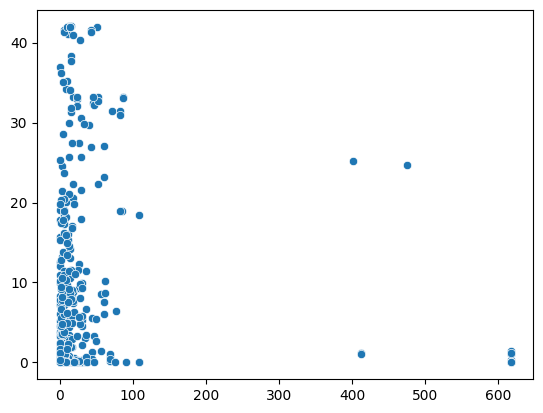

In [7]:
trainer = run(cfg) # run the finetuning, takes around 2 hours on one RTX 3090
cfg.finetune.checkpoint = "./checkpoint-best.pth"
print("checkpoint path:", trainer.checkpoint_callback.best_model_path)

It's almost converged so I stopped it.

 ## Finetune Run 2
 Without a checkpoint.

In [8]:
cfg = load_config('finetune_tutorial_pbmc') # load the predefined finetune tutorial config
cfg.stage = 'fit'
cfg.run.run_name = 'training_from_finetune_no_lora_chr1_split_QATAC_no_checkpoint'
cfg.dataset.quantitative_atac = True # We use binary ATAC signal for motif interpretation analysis

cfg.dataset.zarr_path = "/project/home/p200469/get_BIO1018/get_preprocess_output.zarr/"
cfg.dataset.celltypes = "all_chrs"

# Set a unique project name for training on all chromosomes
cfg.run.project_name = 'finetune_all_chrs'
cfg.dataset.celltypes = "all_chrs"
cfg.finetune.checkpoint = None #Maybe not using a checkpoint made for a different type of cell will work better.
cfg.dataset.leave_out_celltypes = '' # set the celltypes you want to leave out, '' here means no celltype leave out
cfg.dataset.leave_out_chromosomes = 'chr1' # set the chromosomes you want to leave out, '' here means no chromosome leave out
cfg.machine.num_devices=0 # use 0 for cpu training; >=1 for gpu training
cfg.machine.batch_size=8 # batch size for training; check `nvidia-smi` to see the available GPU memory
cfg.finetune.use_lora = False

cfg.machine.output_dir = "/project/home/p200469/get_BIO1018/get_ML_output"
cfg.training.epochs = 50

cfg.training.val_check_interval = 5.0 

print(f"output path: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}")
print(f"training for {cfg.training.epochs} epochs")

output path: /project/home/p200469/get_BIO1018/get_ML_output/finetune_all_chrs/training_from_finetune_no_lora_chr1_split_QATAC_no_checkpoint
training for 50 epochs


Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.


100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.99it/s]


Leave out chromosomes: ['chr1']
Input chromosomes: ['chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX']


100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.25it/s]

Leave out chromosomes: ['chr1']
Input chromosomes: ['chr1']


Sanity Checking: |                                                     | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=25). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
exp_pearson,▆▁▂▃▂▇▇██▇▇▇█▆▅▇▇▆█▇▇▇▇█▇▇▇▆▅▇▆▇▇▇▇▇▇▇▇▇
exp_r2,▄▃▄▁▄█▇▇▇▆▆▆▇▇▇▆▆▅▄▆▅▄▃▄▄▅▃▄▄▄▄▄▄▃▃▄▄▃▄▃
exp_spearman,▅▇▅▇▆▆▅▄▆▅▄▆█▇▆▇▃▇▃▂▇▄▄▅▄▆██▆▆▅▃▄▃▁▃▁▂▁▃
train_exp_loss,███▇▆▆▄▆▇▇▆█▆▆▇▇▅▆▃▆▇▅▃▃▅▂▇▇▅▆▁▇▆▂▆▁▅▆
train_loss,███▇▆▆▄▆▇▇▆█▆▆▇▇▅▆▃▆▇▅▃▃▅▂▇▇▅▆▁▇▆▂▆▁▅▆
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
val_exp_loss,▆▅▇▅▅▂▂▁▂▂▆▃█▂▄▂▂▃▃▄▄▆▅▆▄▆▆▅▆▄▆▅▆▅▇▇▆▆▅▇
val_loss,▅▅▁▂▁▁▁▂▂▃▆▃▃█▄▂▃▃▃▆▄▄▄▄▅▆▄▅▆▄▅▅▆▇▄█▅▇█▆
epoch,49
exp_pearson,0.03649


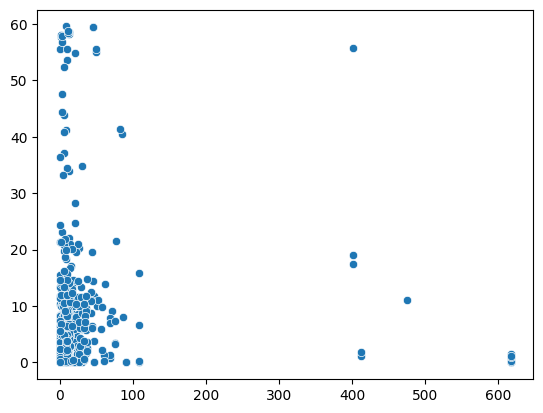

In [9]:
# first run the model without initializing with a finetune checkpoint
cfg.finetune.checkpoint = None
cfg.run.use_wandb = True
trainer = run(cfg)

 ## Finetune Run 3
 With previous pretrain checkpoint.

# Interpretation

After finetuning, we can use the checkpoint to predict expression of all accessible genes and generate jacobian matrix of (peak x motif) for every predicted genes. 
To start, we need to collect the checkpoint we produced and switch to `predict` stage. Here, let's focus on CD4 Naive cell and we need to set `cfg.leave_out_celltypes` to `cd4_naive` for the model to predict gene expression in this cell type.

In [13]:
use_checkpoint = '/project/home/p200469/get_BIO1018/get_ML_output/finetune_all_chrs/training_from_finetune_lora_chr1_split_QATAC/checkpoints/best.ckpt'
cfg.stage = 'predict'
cfg.finetune.resume_ckpt = use_checkpoint

cfg.dataset.celltypes = "all_chrs"

cfg.run.use_wandb = False # disable wandb logging when predicting
cfg.task.layer_names = [] # set to empty list to disable intermediate layer interpretation
cfg.task.gene_list = None # set to None to predict all genes; otherwise you can specify a list of genes as 'MYC,SOX10,SOX2,RET', only genes with promoter open will be used
# loop through all celltypes and run the predict stage
cfg.run.run_name='interpret_training_from_finetune_lora_chr1_split_QATAC'

cfg.dataset.leave_out_celltypes = ''
trainer = run(cfg)

# Pearson 0.896
# R^2 0.793
# Spearman 0.803

Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from /project/home/p200469/get_BIO1018/get_ML_output/pretrain_all_chrs/pretrain_mcf7_from_pretrain_no_lora/checkpoints/best.ckpt


RuntimeError: Error(s) in loading state_dict for GETRegionFinetune:
	Missing key(s) in state_dict: "cls_token", "region_embed.embed.weight", "region_embed.embed.bias", "encoder.blocks.0.norm1.weight", "encoder.blocks.0.norm1.bias", "encoder.blocks.0.attn.q_bias", "encoder.blocks.0.attn.v_bias", "encoder.blocks.0.attn.qkv.weight", "encoder.blocks.0.attn.proj.weight", "encoder.blocks.0.attn.proj.bias", "encoder.blocks.0.norm2.weight", "encoder.blocks.0.norm2.bias", "encoder.blocks.0.mlp.fc1.weight", "encoder.blocks.0.mlp.fc1.bias", "encoder.blocks.0.mlp.fc2.weight", "encoder.blocks.0.mlp.fc2.bias", "encoder.blocks.1.norm1.weight", "encoder.blocks.1.norm1.bias", "encoder.blocks.1.attn.q_bias", "encoder.blocks.1.attn.v_bias", "encoder.blocks.1.attn.qkv.weight", "encoder.blocks.1.attn.proj.weight", "encoder.blocks.1.attn.proj.bias", "encoder.blocks.1.norm2.weight", "encoder.blocks.1.norm2.bias", "encoder.blocks.1.mlp.fc1.weight", "encoder.blocks.1.mlp.fc1.bias", "encoder.blocks.1.mlp.fc2.weight", "encoder.blocks.1.mlp.fc2.bias", "encoder.blocks.2.norm1.weight", "encoder.blocks.2.norm1.bias", "encoder.blocks.2.attn.q_bias", "encoder.blocks.2.attn.v_bias", "encoder.blocks.2.attn.qkv.weight", "encoder.blocks.2.attn.proj.weight", "encoder.blocks.2.attn.proj.bias", "encoder.blocks.2.norm2.weight", "encoder.blocks.2.norm2.bias", "encoder.blocks.2.mlp.fc1.weight", "encoder.blocks.2.mlp.fc1.bias", "encoder.blocks.2.mlp.fc2.weight", "encoder.blocks.2.mlp.fc2.bias", "encoder.blocks.3.norm1.weight", "encoder.blocks.3.norm1.bias", "encoder.blocks.3.attn.q_bias", "encoder.blocks.3.attn.v_bias", "encoder.blocks.3.attn.qkv.weight", "encoder.blocks.3.attn.proj.weight", "encoder.blocks.3.attn.proj.bias", "encoder.blocks.3.norm2.weight", "encoder.blocks.3.norm2.bias", "encoder.blocks.3.mlp.fc1.weight", "encoder.blocks.3.mlp.fc1.bias", "encoder.blocks.3.mlp.fc2.weight", "encoder.blocks.3.mlp.fc2.bias", "encoder.blocks.4.norm1.weight", "encoder.blocks.4.norm1.bias", "encoder.blocks.4.attn.q_bias", "encoder.blocks.4.attn.v_bias", "encoder.blocks.4.attn.qkv.weight", "encoder.blocks.4.attn.proj.weight", "encoder.blocks.4.attn.proj.bias", "encoder.blocks.4.norm2.weight", "encoder.blocks.4.norm2.bias", "encoder.blocks.4.mlp.fc1.weight", "encoder.blocks.4.mlp.fc1.bias", "encoder.blocks.4.mlp.fc2.weight", "encoder.blocks.4.mlp.fc2.bias", "encoder.blocks.5.norm1.weight", "encoder.blocks.5.norm1.bias", "encoder.blocks.5.attn.q_bias", "encoder.blocks.5.attn.v_bias", "encoder.blocks.5.attn.qkv.weight", "encoder.blocks.5.attn.proj.weight", "encoder.blocks.5.attn.proj.bias", "encoder.blocks.5.norm2.weight", "encoder.blocks.5.norm2.bias", "encoder.blocks.5.mlp.fc1.weight", "encoder.blocks.5.mlp.fc1.bias", "encoder.blocks.5.mlp.fc2.weight", "encoder.blocks.5.mlp.fc2.bias", "encoder.blocks.6.norm1.weight", "encoder.blocks.6.norm1.bias", "encoder.blocks.6.attn.q_bias", "encoder.blocks.6.attn.v_bias", "encoder.blocks.6.attn.qkv.weight", "encoder.blocks.6.attn.proj.weight", "encoder.blocks.6.attn.proj.bias", "encoder.blocks.6.norm2.weight", "encoder.blocks.6.norm2.bias", "encoder.blocks.6.mlp.fc1.weight", "encoder.blocks.6.mlp.fc1.bias", "encoder.blocks.6.mlp.fc2.weight", "encoder.blocks.6.mlp.fc2.bias", "encoder.blocks.7.norm1.weight", "encoder.blocks.7.norm1.bias", "encoder.blocks.7.attn.q_bias", "encoder.blocks.7.attn.v_bias", "encoder.blocks.7.attn.qkv.weight", "encoder.blocks.7.attn.proj.weight", "encoder.blocks.7.attn.proj.bias", "encoder.blocks.7.norm2.weight", "encoder.blocks.7.norm2.bias", "encoder.blocks.7.mlp.fc1.weight", "encoder.blocks.7.mlp.fc1.bias", "encoder.blocks.7.mlp.fc2.weight", "encoder.blocks.7.mlp.fc2.bias", "encoder.blocks.8.norm1.weight", "encoder.blocks.8.norm1.bias", "encoder.blocks.8.attn.q_bias", "encoder.blocks.8.attn.v_bias", "encoder.blocks.8.attn.qkv.weight", "encoder.blocks.8.attn.proj.weight", "encoder.blocks.8.attn.proj.bias", "encoder.blocks.8.norm2.weight", "encoder.blocks.8.norm2.bias", "encoder.blocks.8.mlp.fc1.weight", "encoder.blocks.8.mlp.fc1.bias", "encoder.blocks.8.mlp.fc2.weight", "encoder.blocks.8.mlp.fc2.bias", "encoder.blocks.9.norm1.weight", "encoder.blocks.9.norm1.bias", "encoder.blocks.9.attn.q_bias", "encoder.blocks.9.attn.v_bias", "encoder.blocks.9.attn.qkv.weight", "encoder.blocks.9.attn.proj.weight", "encoder.blocks.9.attn.proj.bias", "encoder.blocks.9.norm2.weight", "encoder.blocks.9.norm2.bias", "encoder.blocks.9.mlp.fc1.weight", "encoder.blocks.9.mlp.fc1.bias", "encoder.blocks.9.mlp.fc2.weight", "encoder.blocks.9.mlp.fc2.bias", "encoder.blocks.10.norm1.weight", "encoder.blocks.10.norm1.bias", "encoder.blocks.10.attn.q_bias", "encoder.blocks.10.attn.v_bias", "encoder.blocks.10.attn.qkv.weight", "encoder.blocks.10.attn.proj.weight", "encoder.blocks.10.attn.proj.bias", "encoder.blocks.10.norm2.weight", "encoder.blocks.10.norm2.bias", "encoder.blocks.10.mlp.fc1.weight", "encoder.blocks.10.mlp.fc1.bias", "encoder.blocks.10.mlp.fc2.weight", "encoder.blocks.10.mlp.fc2.bias", "encoder.blocks.11.norm1.weight", "encoder.blocks.11.norm1.bias", "encoder.blocks.11.attn.q_bias", "encoder.blocks.11.attn.v_bias", "encoder.blocks.11.attn.qkv.weight", "encoder.blocks.11.attn.proj.weight", "encoder.blocks.11.attn.proj.bias", "encoder.blocks.11.norm2.weight", "encoder.blocks.11.norm2.bias", "encoder.blocks.11.mlp.fc1.weight", "encoder.blocks.11.mlp.fc1.bias", "encoder.blocks.11.mlp.fc2.weight", "encoder.blocks.11.mlp.fc2.bias", "encoder.norm.weight", "encoder.norm.bias", "head_exp.head.weight", "head_exp.head.bias". 
	Unexpected key(s) in state_dict: "model.mask_token", "model.cls_token", "model.region_embed.embed.weight", "model.region_embed.embed.bias", "model.encoder.encoder.blocks.0.norm1.weight", "model.encoder.encoder.blocks.0.norm1.bias", "model.encoder.encoder.blocks.0.attn.q_bias", "model.encoder.encoder.blocks.0.attn.v_bias", "model.encoder.encoder.blocks.0.attn.qkv.weight", "model.encoder.encoder.blocks.0.attn.proj.weight", "model.encoder.encoder.blocks.0.attn.proj.bias", "model.encoder.encoder.blocks.0.norm2.weight", "model.encoder.encoder.blocks.0.norm2.bias", "model.encoder.encoder.blocks.0.mlp.fc1.weight", "model.encoder.encoder.blocks.0.mlp.fc1.bias", "model.encoder.encoder.blocks.0.mlp.fc2.weight", "model.encoder.encoder.blocks.0.mlp.fc2.bias", "model.encoder.encoder.blocks.1.norm1.weight", "model.encoder.encoder.blocks.1.norm1.bias", "model.encoder.encoder.blocks.1.attn.q_bias", "model.encoder.encoder.blocks.1.attn.v_bias", "model.encoder.encoder.blocks.1.attn.qkv.weight", "model.encoder.encoder.blocks.1.attn.proj.weight", "model.encoder.encoder.blocks.1.attn.proj.bias", "model.encoder.encoder.blocks.1.norm2.weight", "model.encoder.encoder.blocks.1.norm2.bias", "model.encoder.encoder.blocks.1.mlp.fc1.weight", "model.encoder.encoder.blocks.1.mlp.fc1.bias", "model.encoder.encoder.blocks.1.mlp.fc2.weight", "model.encoder.encoder.blocks.1.mlp.fc2.bias", "model.encoder.encoder.blocks.2.norm1.weight", "model.encoder.encoder.blocks.2.norm1.bias", "model.encoder.encoder.blocks.2.attn.q_bias", "model.encoder.encoder.blocks.2.attn.v_bias", "model.encoder.encoder.blocks.2.attn.qkv.weight", "model.encoder.encoder.blocks.2.attn.proj.weight", "model.encoder.encoder.blocks.2.attn.proj.bias", "model.encoder.encoder.blocks.2.norm2.weight", "model.encoder.encoder.blocks.2.norm2.bias", "model.encoder.encoder.blocks.2.mlp.fc1.weight", "model.encoder.encoder.blocks.2.mlp.fc1.bias", "model.encoder.encoder.blocks.2.mlp.fc2.weight", "model.encoder.encoder.blocks.2.mlp.fc2.bias", "model.encoder.encoder.blocks.3.norm1.weight", "model.encoder.encoder.blocks.3.norm1.bias", "model.encoder.encoder.blocks.3.attn.q_bias", "model.encoder.encoder.blocks.3.attn.v_bias", "model.encoder.encoder.blocks.3.attn.qkv.weight", "model.encoder.encoder.blocks.3.attn.proj.weight", "model.encoder.encoder.blocks.3.attn.proj.bias", "model.encoder.encoder.blocks.3.norm2.weight", "model.encoder.encoder.blocks.3.norm2.bias", "model.encoder.encoder.blocks.3.mlp.fc1.weight", "model.encoder.encoder.blocks.3.mlp.fc1.bias", "model.encoder.encoder.blocks.3.mlp.fc2.weight", "model.encoder.encoder.blocks.3.mlp.fc2.bias", "model.encoder.encoder.blocks.4.norm1.weight", "model.encoder.encoder.blocks.4.norm1.bias", "model.encoder.encoder.blocks.4.attn.q_bias", "model.encoder.encoder.blocks.4.attn.v_bias", "model.encoder.encoder.blocks.4.attn.qkv.weight", "model.encoder.encoder.blocks.4.attn.proj.weight", "model.encoder.encoder.blocks.4.attn.proj.bias", "model.encoder.encoder.blocks.4.norm2.weight", "model.encoder.encoder.blocks.4.norm2.bias", "model.encoder.encoder.blocks.4.mlp.fc1.weight", "model.encoder.encoder.blocks.4.mlp.fc1.bias", "model.encoder.encoder.blocks.4.mlp.fc2.weight", "model.encoder.encoder.blocks.4.mlp.fc2.bias", "model.encoder.encoder.blocks.5.norm1.weight", "model.encoder.encoder.blocks.5.norm1.bias", "model.encoder.encoder.blocks.5.attn.q_bias", "model.encoder.encoder.blocks.5.attn.v_bias", "model.encoder.encoder.blocks.5.attn.qkv.weight", "model.encoder.encoder.blocks.5.attn.proj.weight", "model.encoder.encoder.blocks.5.attn.proj.bias", "model.encoder.encoder.blocks.5.norm2.weight", "model.encoder.encoder.blocks.5.norm2.bias", "model.encoder.encoder.blocks.5.mlp.fc1.weight", "model.encoder.encoder.blocks.5.mlp.fc1.bias", "model.encoder.encoder.blocks.5.mlp.fc2.weight", "model.encoder.encoder.blocks.5.mlp.fc2.bias", "model.encoder.encoder.blocks.6.norm1.weight", "model.encoder.encoder.blocks.6.norm1.bias", "model.encoder.encoder.blocks.6.attn.q_bias", "model.encoder.encoder.blocks.6.attn.v_bias", "model.encoder.encoder.blocks.6.attn.qkv.weight", "model.encoder.encoder.blocks.6.attn.proj.weight", "model.encoder.encoder.blocks.6.attn.proj.bias", "model.encoder.encoder.blocks.6.norm2.weight", "model.encoder.encoder.blocks.6.norm2.bias", "model.encoder.encoder.blocks.6.mlp.fc1.weight", "model.encoder.encoder.blocks.6.mlp.fc1.bias", "model.encoder.encoder.blocks.6.mlp.fc2.weight", "model.encoder.encoder.blocks.6.mlp.fc2.bias", "model.encoder.encoder.blocks.7.norm1.weight", "model.encoder.encoder.blocks.7.norm1.bias", "model.encoder.encoder.blocks.7.attn.q_bias", "model.encoder.encoder.blocks.7.attn.v_bias", "model.encoder.encoder.blocks.7.attn.qkv.weight", "model.encoder.encoder.blocks.7.attn.proj.weight", "model.encoder.encoder.blocks.7.attn.proj.bias", "model.encoder.encoder.blocks.7.norm2.weight", "model.encoder.encoder.blocks.7.norm2.bias", "model.encoder.encoder.blocks.7.mlp.fc1.weight", "model.encoder.encoder.blocks.7.mlp.fc1.bias", "model.encoder.encoder.blocks.7.mlp.fc2.weight", "model.encoder.encoder.blocks.7.mlp.fc2.bias", "model.encoder.encoder.blocks.8.norm1.weight", "model.encoder.encoder.blocks.8.norm1.bias", "model.encoder.encoder.blocks.8.attn.q_bias", "model.encoder.encoder.blocks.8.attn.v_bias", "model.encoder.encoder.blocks.8.attn.qkv.weight", "model.encoder.encoder.blocks.8.attn.proj.weight", "model.encoder.encoder.blocks.8.attn.proj.bias", "model.encoder.encoder.blocks.8.norm2.weight", "model.encoder.encoder.blocks.8.norm2.bias", "model.encoder.encoder.blocks.8.mlp.fc1.weight", "model.encoder.encoder.blocks.8.mlp.fc1.bias", "model.encoder.encoder.blocks.8.mlp.fc2.weight", "model.encoder.encoder.blocks.8.mlp.fc2.bias", "model.encoder.encoder.blocks.9.norm1.weight", "model.encoder.encoder.blocks.9.norm1.bias", "model.encoder.encoder.blocks.9.attn.q_bias", "model.encoder.encoder.blocks.9.attn.v_bias", "model.encoder.encoder.blocks.9.attn.qkv.weight", "model.encoder.encoder.blocks.9.attn.proj.weight", "model.encoder.encoder.blocks.9.attn.proj.bias", "model.encoder.encoder.blocks.9.norm2.weight", "model.encoder.encoder.blocks.9.norm2.bias", "model.encoder.encoder.blocks.9.mlp.fc1.weight", "model.encoder.encoder.blocks.9.mlp.fc1.bias", "model.encoder.encoder.blocks.9.mlp.fc2.weight", "model.encoder.encoder.blocks.9.mlp.fc2.bias", "model.encoder.encoder.blocks.10.norm1.weight", "model.encoder.encoder.blocks.10.norm1.bias", "model.encoder.encoder.blocks.10.attn.q_bias", "model.encoder.encoder.blocks.10.attn.v_bias", "model.encoder.encoder.blocks.10.attn.qkv.weight", "model.encoder.encoder.blocks.10.attn.proj.weight", "model.encoder.encoder.blocks.10.attn.proj.bias", "model.encoder.encoder.blocks.10.norm2.weight", "model.encoder.encoder.blocks.10.norm2.bias", "model.encoder.encoder.blocks.10.mlp.fc1.weight", "model.encoder.encoder.blocks.10.mlp.fc1.bias", "model.encoder.encoder.blocks.10.mlp.fc2.weight", "model.encoder.encoder.blocks.10.mlp.fc2.bias", "model.encoder.encoder.blocks.11.norm1.weight", "model.encoder.encoder.blocks.11.norm1.bias", "model.encoder.encoder.blocks.11.attn.q_bias", "model.encoder.encoder.blocks.11.attn.v_bias", "model.encoder.encoder.blocks.11.attn.qkv.weight", "model.encoder.encoder.blocks.11.attn.proj.weight", "model.encoder.encoder.blocks.11.attn.proj.bias", "model.encoder.encoder.blocks.11.norm2.weight", "model.encoder.encoder.blocks.11.norm2.bias", "model.encoder.encoder.blocks.11.mlp.fc1.weight", "model.encoder.encoder.blocks.11.mlp.fc1.bias", "model.encoder.encoder.blocks.11.mlp.fc2.weight", "model.encoder.encoder.blocks.11.mlp.fc2.bias", "model.encoder.norm.weight", "model.encoder.norm.bias", "model.head_mask.weight", "model.head_mask.bias". 

As you can see, the results is now saved to `finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split/cd4_naive.zarr`. Now we can use the `GETHydraCellType` class from `gcell` to load it.

### Load interpretation result as `GETHydraCellType`

In [ ]:
# Set dataset celltype to "all_chrs"
cfg.dataset.celltypes = "all_chrs"

# Load the configuration
cfg = load_config('finetune_tutorial_pbmc')

# Update the run name
cfg.run.run_name = 'interpret_training_from_finetune_lora_all_chrs_QATAC'

# Create a gene annotation dictionary
gene_annot_dict = {}

try:
    # Since celltypes is "all_chrs", set `leave_out_celltypes` to None
    cfg.dataset.leave_out_celltypes = None
    
    # Load data for all chromosomes
    hydra_celltype = GETHydraCellType.from_config(cfg, celltype="all_chrs")
    
    # Save the gene annotations for "all_chrs"
    gene_annot_dict["all_chrs"] = hydra_celltype.gene_annot

except Exception as e:
    print(f"Error loading all_chrs: {e}")

In [ ]:
# For all genes in "all_chrs", collect the predicted and observed expression
import numpy as np
import pandas as pd

try:
    # Get the common intersected gene list for "all_chrs"
    common_gene_list = set(gene_annot_dict["all_chrs"].index)
    
    # Collect the expression for the common gene list
    gene_annot_dict["all_chrs"] = gene_annot_dict["all_chrs"].loc[np.array(common_gene_list)]
    
    # Convert the gene annotations into a DataFrame for easier manipulation and visualization
    gene_expression_df = pd.DataFrame(gene_annot_dict["all_chrs"])
    
    print("Successfully collected gene expressions for all_chrs.")
except Exception as e:
    print(f"Error processing gene annotations for all_chrs: {e}")

gene_annot_dict


In [ ]:
# Create a DataFrame for "all_chrs" excluding genes from chr1
df = gene_annot_dict["all_chrs"] \
    .query('Chromosome == "chr1"') \
    .reset_index()[['obs', 'pred', 'gene_name']] \
    .groupby('gene_name').mean().reset_index()

# Pivot the DataFrame to create columns for 'pred' and 'obs'
df_pred = df.pivot(index='gene_name', values='pred').dropna()
df_obs = df.pivot(index='gene_name', values='obs').dropna()

# Calculate the correlation between predicted and observed expression for each gene
corrs = []
for gene in df_pred.index:
    try:
        corr = df_pred.loc[gene].corr(df_obs.loc[gene])
        corrs.append((corr, df_pred.loc[gene].mean(), df_obs.loc[gene].mean(), gene))
    except Exception as e:
        print(f"Error calculating correlation for {gene}: {e}")
        continue

# Create a DataFrame to store correlations
df_corr = pd.DataFrame(corrs, columns=['corr', 'pred', 'obs', 'gene_name'])

print("Correlation calculation completed.")


In [ ]:
# plot example genes
plt.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
df_corr['corr'].hist(bins=20, ax=ax[0])
# add total number of genes as title
ax[0].set_title(f'Total number of genes: {len(df_corr)}\nshared open genes across MCF-7 \non leave out chr1')
ax[0].set_xlabel('Uniform Clonal Cell Correlation')
ax[0].set_ylabel('Number of Genes')

sns.kdeplot(data=df_corr, x='pred', y='corr', ax=ax[1], shade=True)
ax[1].set_title('Predicted mean vs \nUniform Clonal Cell Correlation')
ax[1].set_xlabel('Predicted Expression')
ax[1].set_ylabel('Uniform Clonal Cell Correlation')
fig.tight_layout()


We can plot the predicted and observed expression to see whether there is any issue.

In [ ]:
df_pred